<div class="alert alert-success">
    <center> <h1> <font size="8"> Multivariate Student-T Example </font> </h1> </center>
    <center> <h1> <font size="5"> Cholesky Decomposition of Covariance Matrix $\Sigma$  </font> </h1> </center>
</div>

<br/>
<br/>

In this example, we model and predict all parameters of a trivariate ($Y_{D}=3$) Student-T distribution. As a generalization of the multivariate Normal, the multivariate Student-T is suitable when modelling heavy-tailed data, i.e., when there is more mass in the tails of the distribution. The multivariate Student-T distribution has an additional degrees of freedom parameter $\mathbf{\nu}_{\mathbf{x}} > 2$ that governs the tail behaviour, where for $\mathbf{\nu}_{\mathbf{x}} \rightarrow \infty$ the Student-T converges in distribution to the multivariate Normal. The conditional means $\mathbf{\mu}(x) \in \mathbb{R}^{D}$ and the conditional covariance matrix $\mathbf{\nu}(x)\big(\mathbf{\nu}(x)-2\big)^{-1}\mathbf{\Sigma}(x) \in \mathbb{R}^{D \times D}$ are given as follows

$$
\mathbf{\mu}(x)=\begin{pmatrix}\mu_{1}(x) \\ \mu_{2}(x) \\ \mu_{3}(x)\end{pmatrix}, \qquad \qquad  
\mathbf{\Sigma}(x)= \begin{pmatrix}
\sigma^{2}_{11}(x) & \rho_{1,2}(x)\sigma_{1}(x)\sigma_{2}(x) & \rho_{1,3}(x)\sigma_{1}(x)\sigma_{3}(x) \\
\rho_{2,1}(x)\sigma_{2}(x)\sigma_{1}(x) & \sigma^{2}_{22}(x) & \rho_{2,3}(x)\sigma_{2}(x)\sigma_{3}(x) \\
\rho_{3,1}(x)\sigma_{3}(x)\sigma_{1}(x) & \rho_{3,2}(x)\sigma_{3}(x)\sigma_{2}(x) &  \sigma^{2}_{33}(x)
\end{pmatrix}
$$

where $\mathbf{\mu}(x)$ and $\mathbf{\Sigma}(x)$ are defined as for the multivariate Normal. To ensure positive definiteness of $\Sigma(\cdot)$, the $D(D + 1)/2$ entries of the covariance matrix must satisfy specific conditions. For the bivariate case, this can be ensured by applying exponential functions to the variances and a suitable transformation to restrict the coefficient of correlation $\rho \in [-1,1]$. However, in high-dimensional settings, where all moments are modelled as functions of covariates, ensuring positive definiteness of the covariance matrix becomes challenging, since joint restrictions for the elements are necessary. A computationally more tractable approach to ensure positive definiteness is based on the Cholesky decomposition, that uniquely decomposes the covariance matrix as follows

$$
\mathbf{\Sigma}(x) = \mathbf{L}(x) \mathbf{L}^{\prime}(x)
$$

where $\mathbf{L}(\cdot) \in \mathbb{R}^{D \times D}$ is a lower triangular matrix. To ensure $\mathbf{\Sigma}(\cdot)$ to be positive definite, the $D$ diagonal elements $\ell_{ii}$ of
$\mathbf{L}(\cdot)$ need to be strictly positive, whereas all $D(D −1)/2$ off diagonal elements $\ell_{ij}$ can take on any value. For the trivariate case, the Cholesky factor $\mathbf{L}(\cdot)$ is given as follows

$$
\mathbf{L}(x)= \begin{pmatrix}
\exp\big(\ell_{11}(x)\big) & 0 & 0 \\
\ell_{21}(x) & \exp\big(\ell_{22}(x)\big) & 0 \\
\ell_{31}(x) & \ell_{32}(x) & \exp\big(\ell_{33}(x)\big)\\
\end{pmatrix}
$$

Given the usefulness of the Cholesky decomposition, instead of estimating the entries of $\mathbf{\Sigma}(\cdot)$ directly, XGboostlss estimates the Cholesky factors $\mathbf{L}(\cdot)$ and then uses these for creating $\mathbf{\Sigma}(\cdot)$. However, in contrast to the original formulation of $\mathbf{\Sigma}(\cdot)$, the elements in $\mathbf{L}(\cdot)$ *do not have any direct interpretation*. Since XGBoostLSS is based on a *one vs. all estimation strategy*, where a separate tree is grown for each distributional parameter, **estimating many parameters for a large dataset can become computationally extremely expensive**. For more details, we refer to our related paper **[März, Alexander (2022), *Multi-Target XGBoostLSS Regression*](https://arxiv.org/abs/2210.06831)**.
<br/>
<br/>

# Imports

In [17]:
from xgboostlss.model import *
from xgboostlss.distributions.MVT import *
from xgboostlss.datasets.data_loader import load_simulated_multivariate_studentT_data

from sklearn.model_selection import train_test_split
import pandas as pd
import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)
n_cpu = multiprocessing.cpu_count()

# Data

In [2]:
data_sim = load_simulated_multivariate_studentT_data()

# Create 60%, 20%, 20% split for train, validation and test 
train, validate, test = np.split(data_sim.sample(frac=1,random_state=123), [int(0.6*len(data_sim)), int(0.8*len(data_sim))])

# Train
x_train = train.filter(regex="x")
y_train = train.filter(regex="y").values
n_targets = y_train.shape[1]
dtrain = xgb.DMatrix(x_train, label=y_train, nthread=n_cpu)

# Validation
x_eval = validate.filter(regex="x")
y_eval = validate.filter(regex="y").values
deval = xgb.DMatrix(x_eval, label=y_eval, nthread=n_cpu)

# Test
x_test = test.filter(regex="x")
y_test = test.filter(regex="y").values
dtest = xgb.DMatrix(x_test, nthread=n_cpu)

# Distribution Selection

In [3]:
# Specifies a multivariate Student-T distribution, using the Cholesky decompoisition. See ?MVT for details.
xgblss = XGBoostLSS(
    MVT(D=n_targets,                      # Specifies the number of targets
        stabilization="None",             # Options are "None", "MAD", "L2".
        response_fn="exp",                # Function to transform the lower-triangular factor of the covariance, e.g., "exp" or "softplus".
        loss_fn="nll"                     # Loss function, i.e., nll.
       )               
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [4]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=20,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-06-22 09:15:06,410] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-06-22 09:16:05,270] Trial 0 finished with value: 6413.5888672 and parameters: {'eta': 0.00015015681268702434, 'max_depth': 10, 'gamma': 0.0005522757165865727, 'subsample': 0.5528145862106946, 'colsample_bytree': 0.520626719874306, 'min_child_weight': 0.0008561271530256406, 'booster': 'gbtree'}. Best is trial 0 with value: 6413.5888672.
[I 2023-06-22 09:17:08,148] Trial 1 finished with value: 6429.0069336 and parameters: {'eta': 8.987086142669043e-05, 'max_depth': 9, 'gamma': 3.838082616905876e-06, 'subsample': 0.6229266642696729, 'colsample_bytree': 0.4639420830560823, 'min_child_weight': 0.0011999874824879088, 'booster': 'gbtree'}. Best is trial 0 with value: 6413.5888672.
[I 2023-06-22 09:17:59,658] Trial 2 finished with value: 5568.4526366 and parameters: {'eta': 0.01908053627257867, 'max_depth': 8, 'gamma': 0.032343331893412645, 'subsample': 0.9097320442665298, 'colsample_bytree': 0.5778612040110485, 'min_child_weight': 0.0013651143838974407, 'booster': 'gbtree'}. Best is t

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Add evaluation set
eval_set = [(dtrain,"train"), (deval,"evaluation")]
eval_result = {}
            
# Train Model with optimized hyperparameters
xgblss.train(
    opt_params,
    dtrain,
    num_boost_round=n_rounds,
    evals=eval_set, 
    evals_result=eval_result,
    verbose_eval=False
)

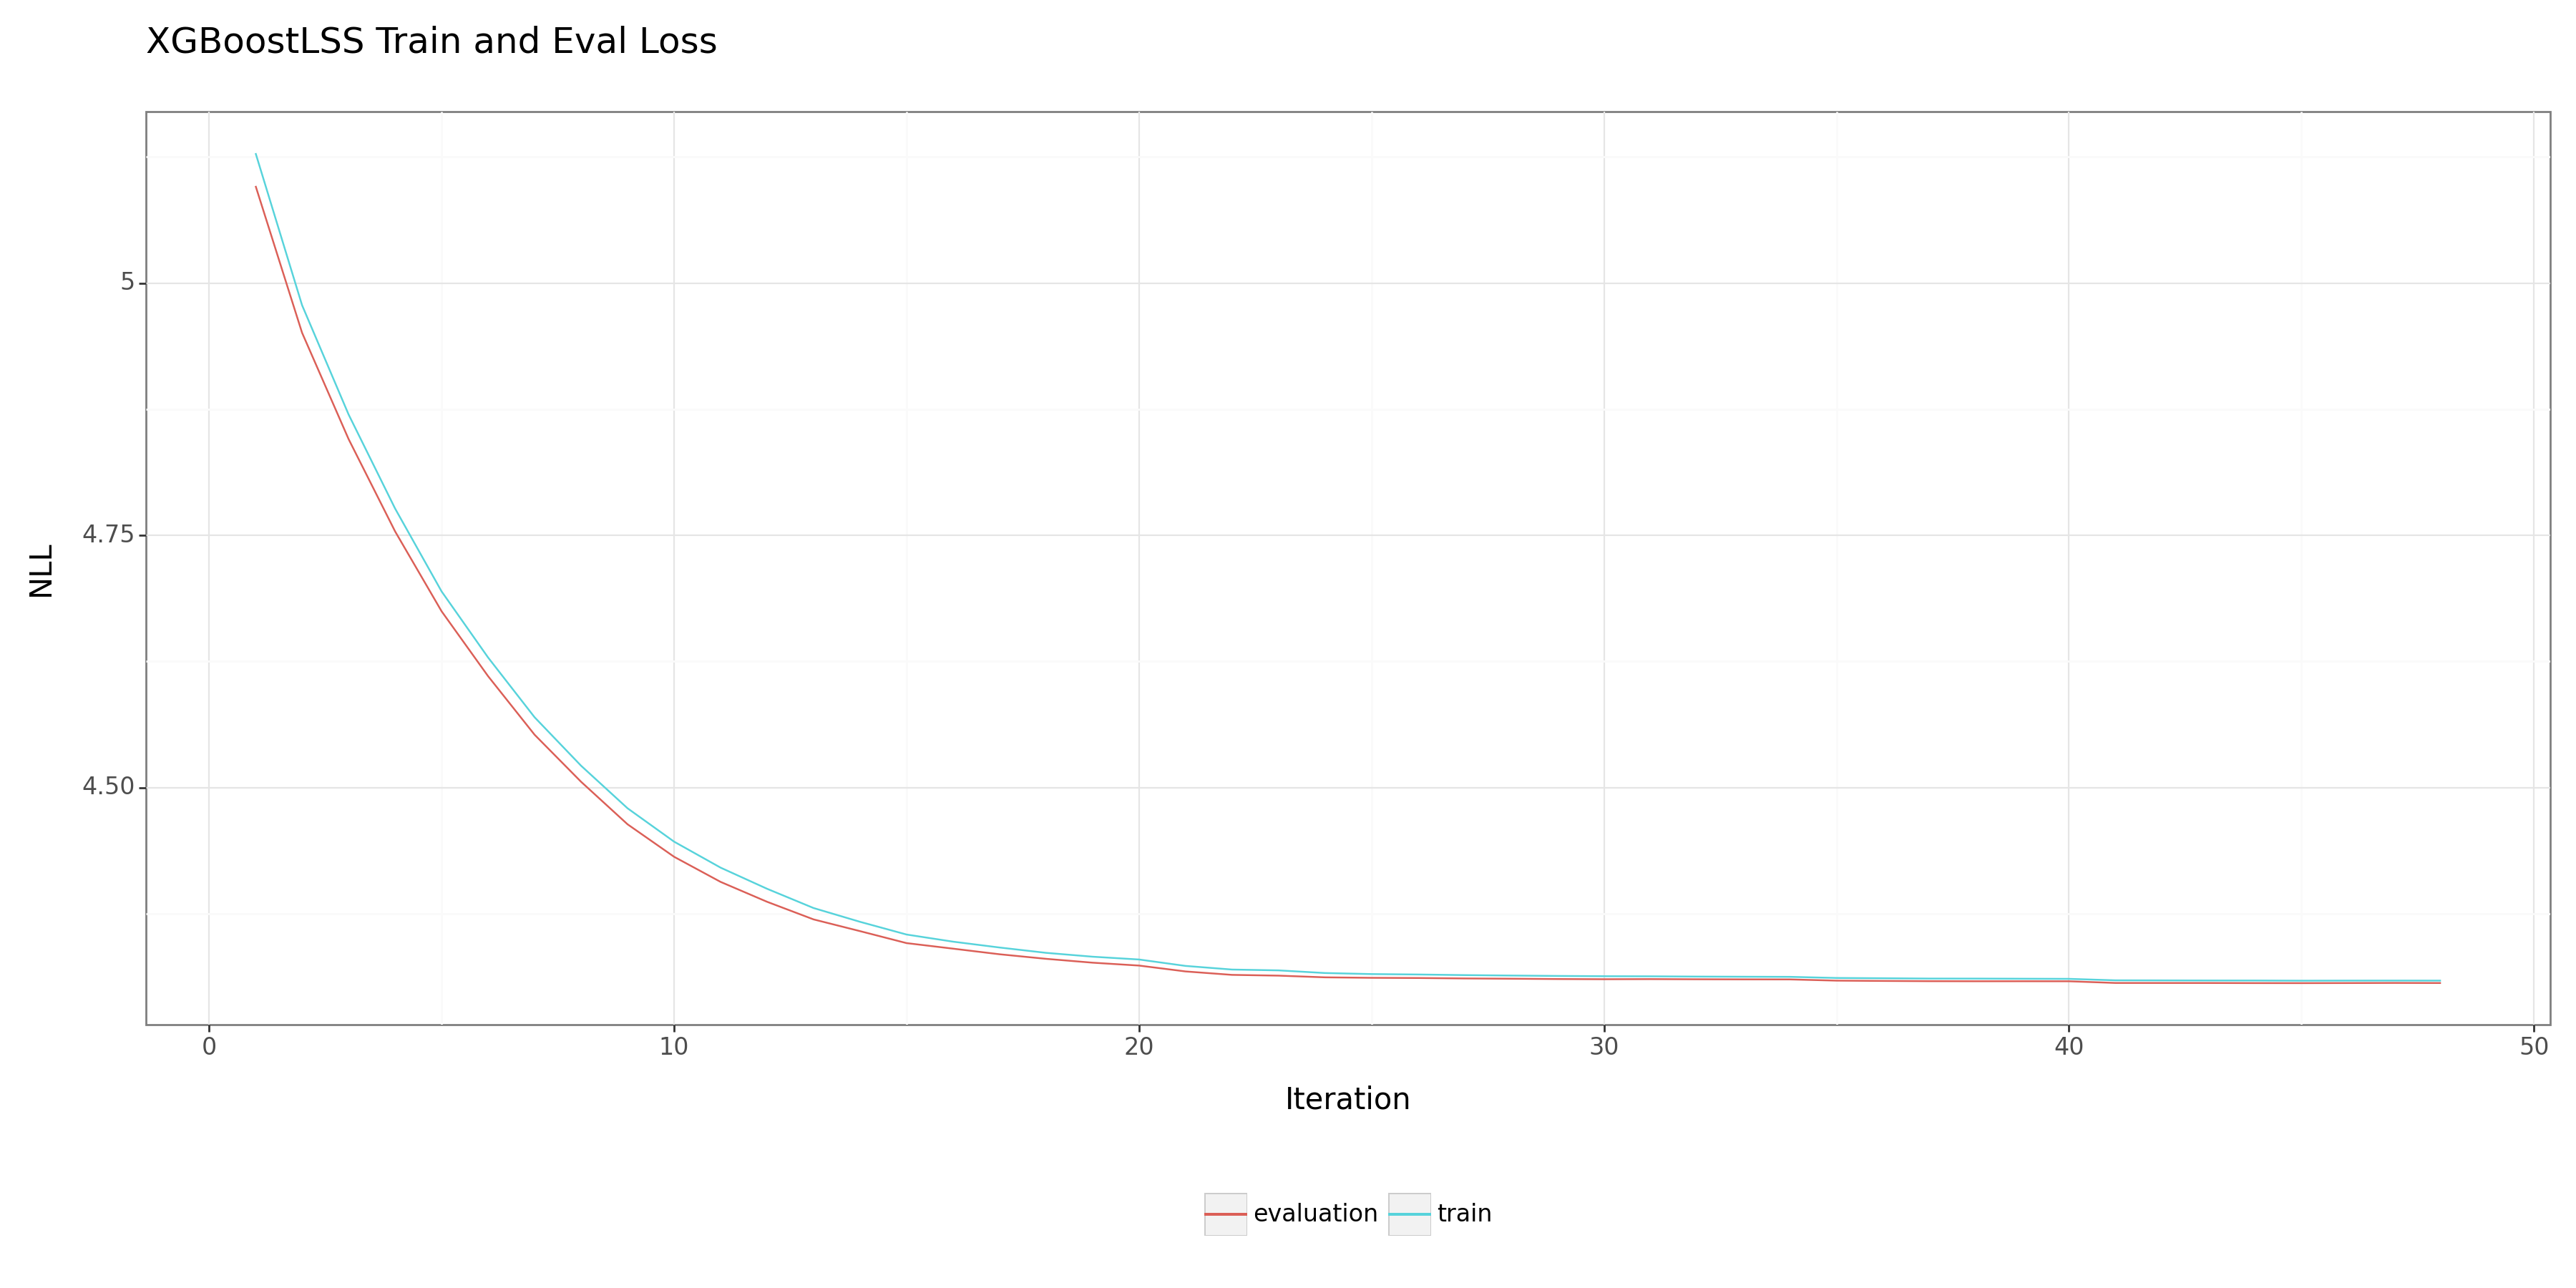

<Figure Size: (1800 x 900)>

In [6]:
# Note that XGBoostLSS uses NLL.sum() instead of NLL.mean() for training, so that train-nll and evaluation-nll are not comparable. Hence we manually adjust them.
n_train = y_train.shape[0],
n_eval =  y_eval.shape[0]

eval_df = pd.DataFrame.from_dict({"train": np.array(eval_result["train"]["nll"]) / n_train,
                                  "evaluation": np.array(eval_result["evaluation"]["nll"]) / n_eval
                                 })
eval_df["iter"] = eval_df.index + 1
eval_df = eval_df.melt(id_vars="iter")

(
    ggplot(eval_df,
           aes(x="iter",
               y="value",
               color="variable")) + 
    geom_line() + 
    labs(title="XGBoostLSS Train and Eval Loss",
         x="Iteration",
         y="NLL") + 
    theme_bw(base_size=15) + 
    theme(legend_position="bottom",
          legend_title = element_blank()
         )
)

# Prediction

In [7]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [8]:
pred_samples.head()

,target,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,y1,1.667932,1.631851,-2.978731,2.746265,2.059820,-1.359539,1.571172,1.759640,2.175634,...,1.043452,0.502470,2.391257,-0.245706,3.900496,0.572212,0.332272,2.604990,1.990996,2.425229
1,y1,-0.512730,0.230016,1.467629,-0.600538,-2.796225,0.919563,0.140832,0.244515,-1.500847,...,5.274843,-0.907351,-0.789502,0.573366,-1.675156,0.222012,-0.917026,0.629812,-0.396039,1.318543
2,y1,0.561088,-0.748004,0.152646,2.687419,-0.009103,1.737594,-0.057163,0.098457,2.692869,...,2.186634,2.075422,0.191973,1.258858,3.128220,0.700489,1.632449,0.053039,1.424659,2.253676
3,y1,-0.553102,1.110543,2.103223,-1.816552,-0.869258,-0.275233,0.267580,0.816164,0.878204,...,-0.082561,-1.204835,-0.934094,1.607494,1.880708,0.125096,1.173582,0.309261,1.180910,-0.961877
4,y1,1.091711,-0.437804,2.668892,1.585261,1.041862,1.933763,1.987233,-6.064761,0.172949,...,-0.087848,3.759326,-0.996257,5.680374,1.832690,0.178290,2.072301,0.520087,0.358304,1.978452


In [9]:
pred_samples.tail()

,target,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
5995,y3,2.442450,1.802108,0.294235,2.372050,1.303846,1.788222,3.237095,1.963390,1.678264,...,1.518361,1.330022,-0.248718,3.776295,0.718719,3.304478,3.345208,1.574800,1.465450,-1.156816
5996,y3,3.541716,1.994839,5.250106,1.521251,1.237782,0.746012,3.503881,1.513360,2.796339,...,0.480239,2.537787,-5.611905,5.063916,3.080128,-0.095438,3.740144,1.901680,2.199507,2.030381
5997,y3,-2.000938,3.227403,0.932215,-0.159020,5.510897,-1.754066,-0.925815,1.880578,2.218145,...,2.134847,0.070474,-3.396575,1.632881,1.128258,1.425672,-1.723589,-5.826797,1.231843,3.264819
5998,y3,3.570446,1.398575,0.566380,0.600210,5.554906,-1.641754,1.428654,2.209597,1.929370,...,1.033945,2.587965,2.678239,-0.107618,0.562443,0.331650,-0.232188,1.253137,-0.764202,1.695968
5999,y3,3.100275,2.419199,1.122570,3.293084,3.787231,1.958845,1.300849,2.526066,2.451000,...,0.761709,3.733524,0.129880,2.505081,1.340040,1.808093,1.821813,3.089517,3.722296,3.513244


In [10]:
pred_quantiles.head()

,target,quant_0.05,quant_0.95
0,y1,-1.392198,3.537370
1,y1,-2.278994,3.741764
2,y1,-1.676229,3.074070
3,y1,-1.688622,2.748100
4,y1,-1.863512,3.838427


In [11]:
pred_params.head()

,df,location_1,location_2,location_3,scale_1,scale_2,scale_3,rho_12,rho_13,rho_23
0,7.865457,0.985213,0.087629,1.068884,1.553091,0.777370,1.867574,0.736455,0.488430,0.303660
1,4.911545,0.594036,-0.114491,1.938422,2.098058,1.042931,2.288096,0.569916,0.664168,0.688709
2,4.911545,0.814066,0.483306,1.057014,1.504512,1.366037,2.469075,0.435115,0.924239,0.663905
3,4.911545,0.595148,0.207500,2.642362,1.549827,1.389336,2.296717,0.465067,0.923410,0.674316
4,4.911545,0.814066,0.127430,1.057014,1.886949,1.207472,2.271021,0.492254,0.835167,0.707119


# SHAP Interpretability

Since XGboostlss estimates the covariance matrix $\mathbf{\Sigma}(x) = \mathbf{L}(x) \mathbf{L}^{\prime}(x)$ via the Cholesky factors, **interpretability is only sensible for the location parameters**. The following parameters have been estimated

In [12]:
list(xgblss.dist.param_dict.keys())

['df',
 'location_1',
 'location_2',
 'location_3',
 'scale_tril_diag_1',
 'scale_tril_offdiag_12',
 'scale_tril_diag_2',
 'scale_tril_offdiag_13',
 'scale_tril_offdiag_23',
 'scale_tril_diag_3']

C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide


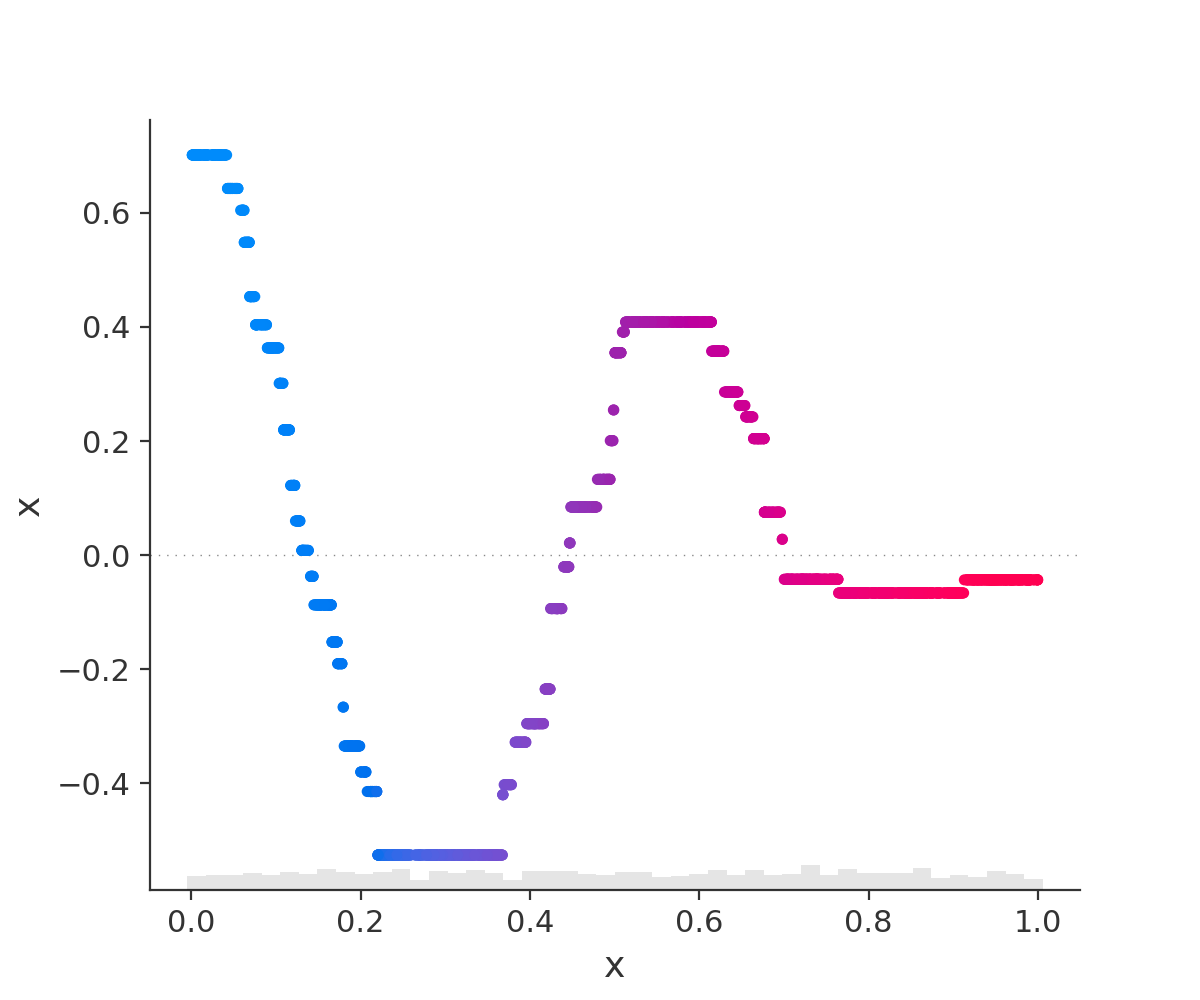

In [13]:
# Partial Dependence Plot of how x acts on location_2
xgblss.plot(x_test,
            parameter="location_2",
            feature="x",
            plot_type="Partial_Dependence")

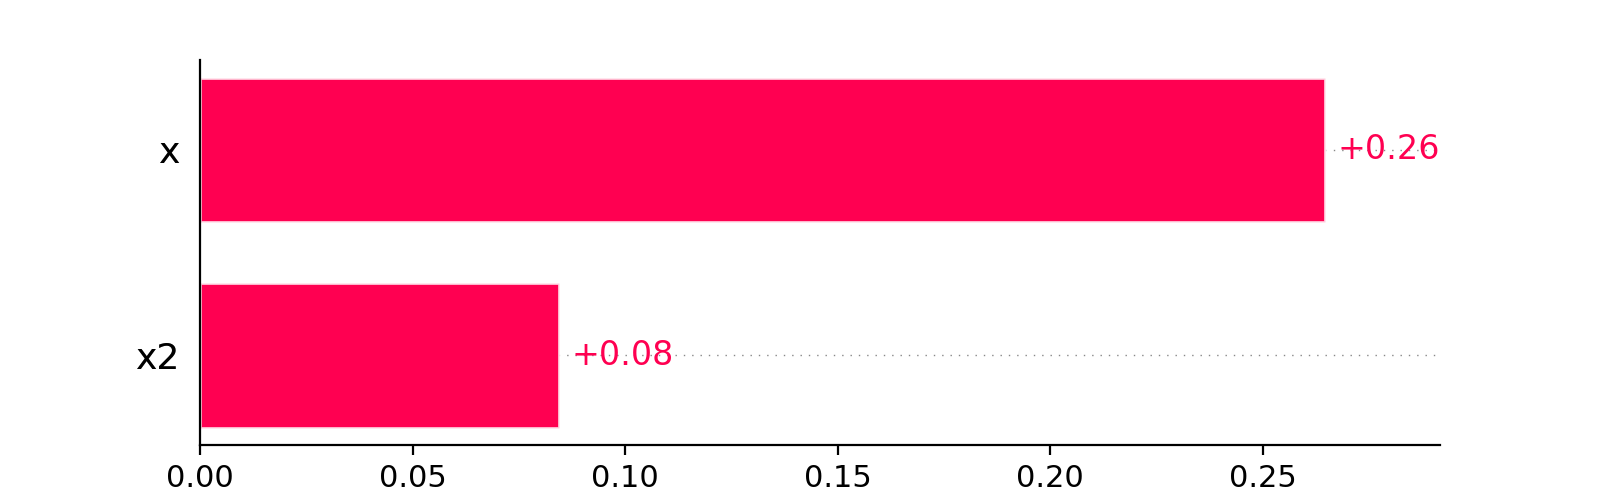

In [14]:
# Feature Importance of location_2 parameter
xgblss.plot(x_test,
            parameter="location_2",
            plot_type="Feature_Importance")

# True vs. Predicted Distributional Parameters

In the following figure, we compare the true parameters of the multivariate Gaussian with the ones predicted by XGBoostLSS. The below figure shows that the estimated parameters closely match the true ones.

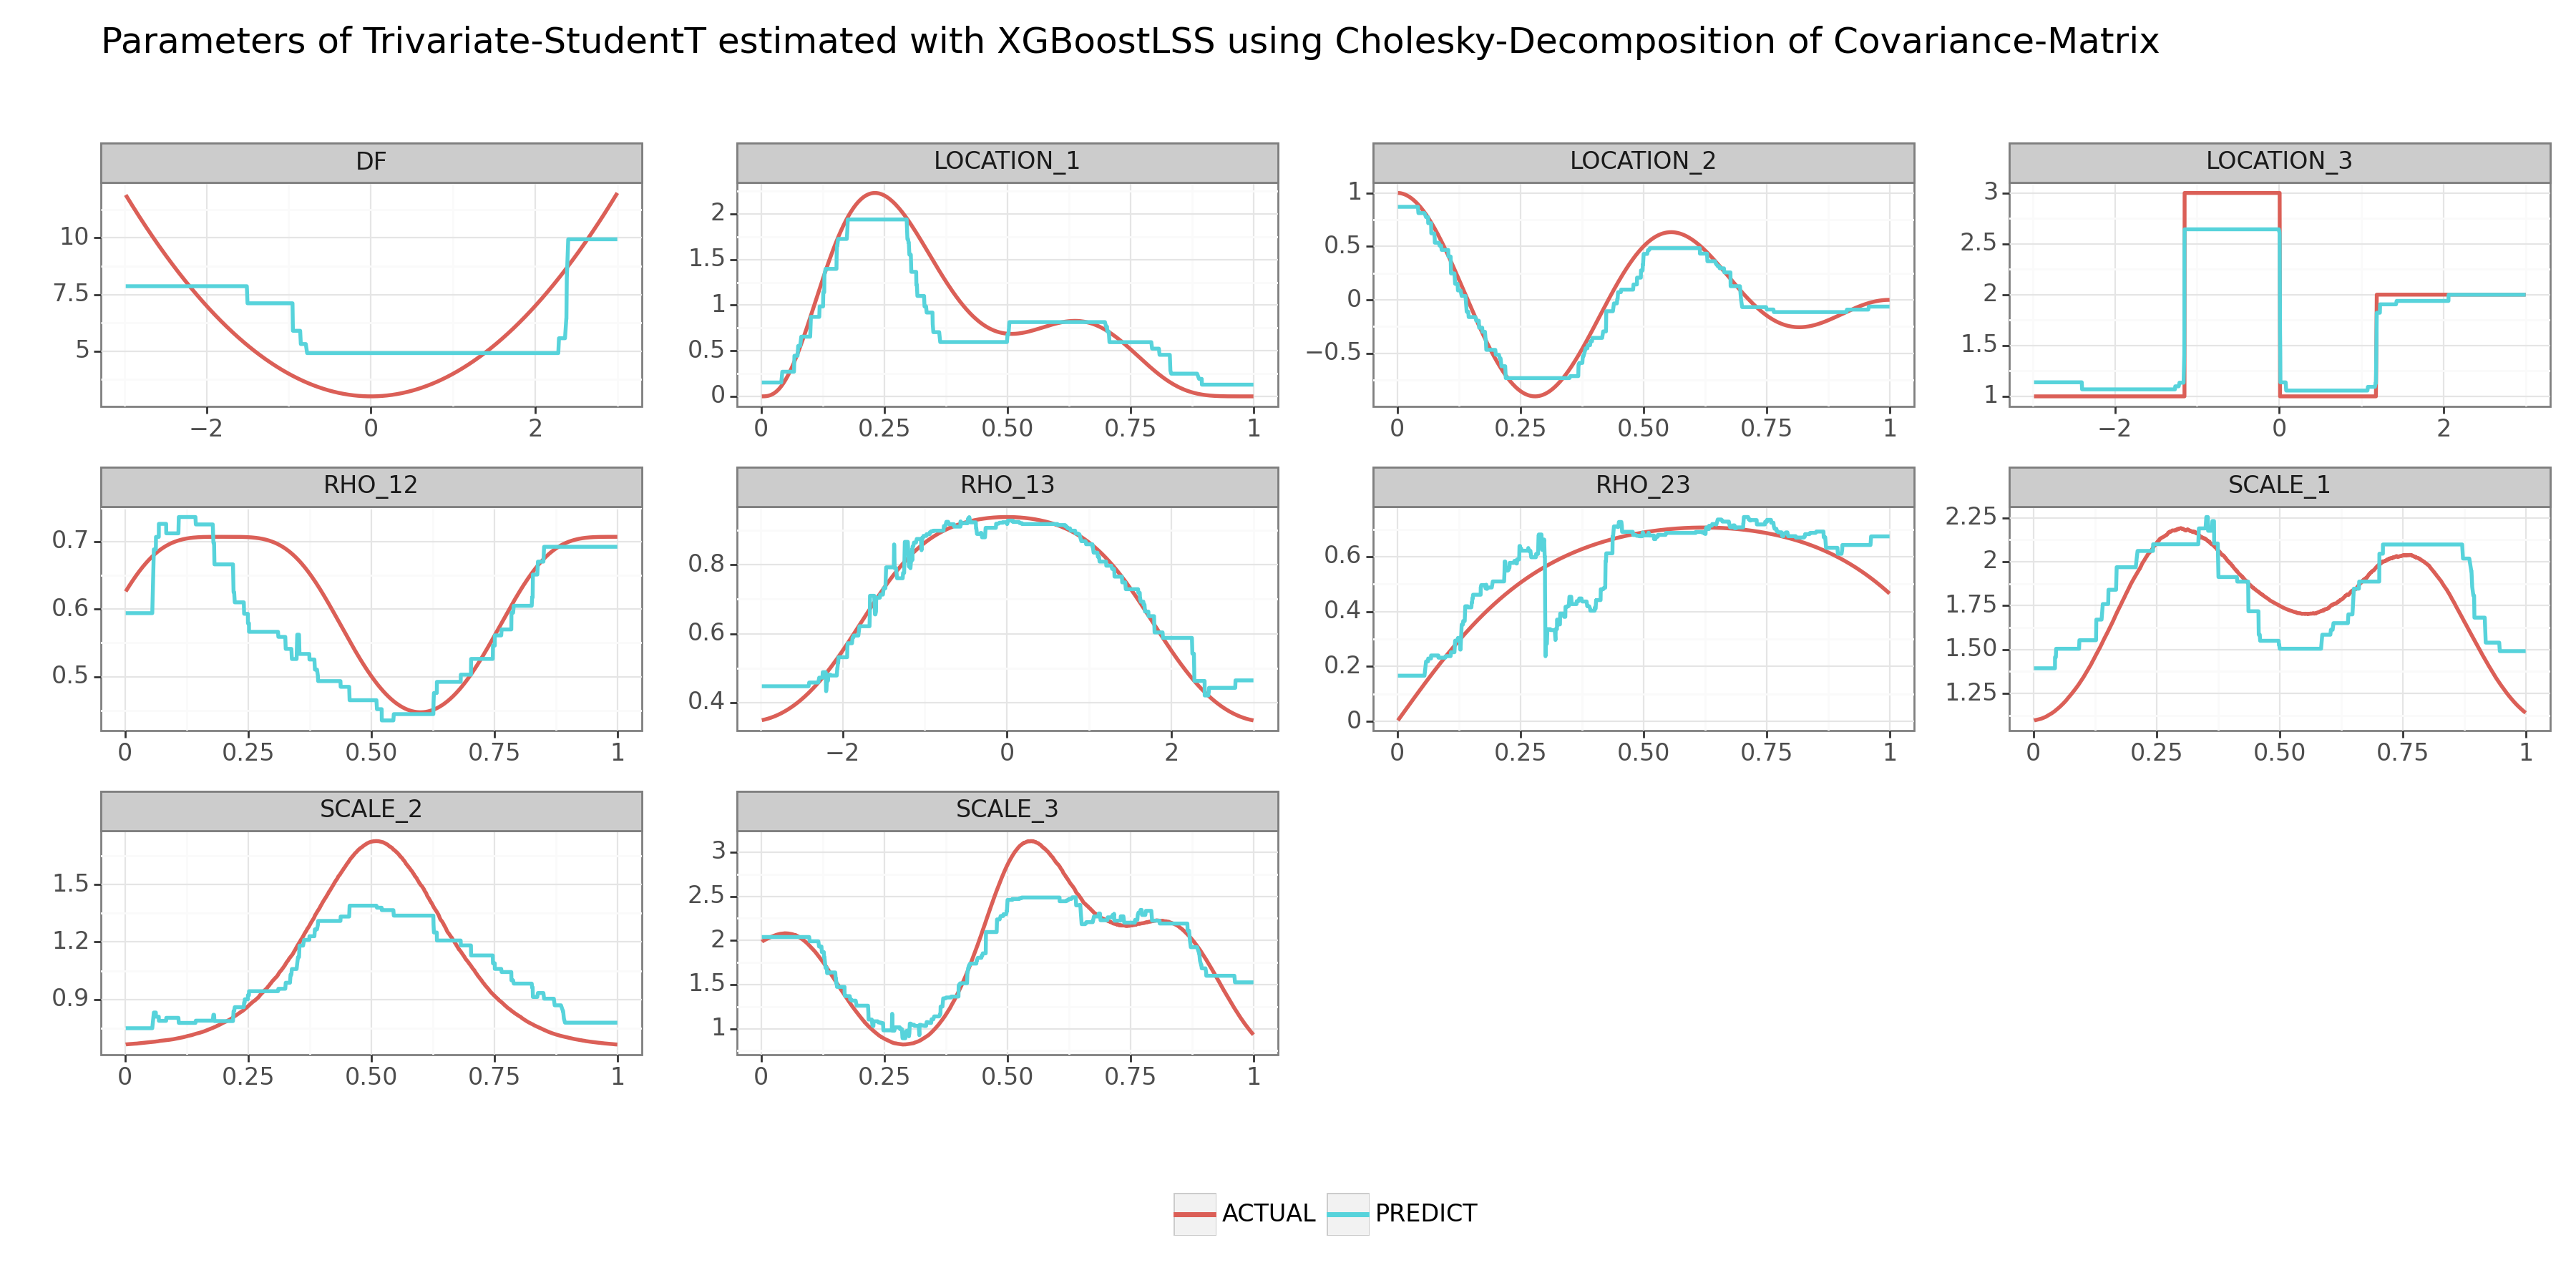

In [15]:
pred_params["x"] = x_test["x"].values
pred_params["x2"] = x_test["x2"].values

# Data with actual values
plot_df_actual1 = pd.melt(test.drop(columns=["y1", "y2", "y3", "x2", "df", "location_3", "rho_13"], axis=0),
                          id_vars=["x"],
                          value_vars=["location_1", "location_2", "scale_1", "rho_12", "scale_2", "rho_23", "scale_3"])

plot_df_actual2 = pd.melt(test.drop(columns=["y1", "y2", "y3", "location_1", "location_2", "scale_1", "rho_12", "scale_2", "rho_23", "scale_3", "x"], axis=0),
                          id_vars=["x2"],
                          value_vars=["df", "location_3", "rho_13"])

plot_df_actual2.columns = list(plot_df_actual1.columns)
plot_df_actual = pd.concat([plot_df_actual1, plot_df_actual2])
plot_df_actual["type"] = "ACTUAL"



# Data with predicted values
plot_df_pred1 = pd.melt(pred_params.drop(columns=["x2", "df", "location_3", "rho_13"], axis=0),
                        id_vars=["x"],
                        value_vars=["location_1", "location_2", "scale_1", "rho_12", "scale_2", "rho_23", "scale_3"])

plot_df_pred2 = pd.melt(pred_params.drop(columns=["location_1", "location_2", "scale_1", "rho_12", "scale_2", "rho_23", "scale_3", "x"], axis=0),
                        id_vars=["x2"],
                        value_vars=["df", "location_3", "rho_13"])

plot_df_pred2.columns = list(plot_df_pred1.columns)
plot_df_predt= pd.concat([plot_df_pred1, plot_df_pred2])
plot_df_predt["type"] = "PREDICT"    


# Concatenated DF
plot_df = pd.concat([plot_df_actual, plot_df_predt])   
plot_df["variable"] = plot_df.variable.str.upper()


plot_params = (ggplot(plot_df,
                      aes(x="x",
                          y="value",
                          color="type")) +
               geom_line(size=1.1) + 
               facet_wrap("variable",
                          scales="free",
                          ncol=4) + 
               labs(title="Parameters of Trivariate-StudentT estimated with XGBoostLSS using Cholesky-Decomposition of Covariance-Matrix\n",
                    x="",
                    y="") + 
               theme_bw(base_size=15) + 
               theme(legend_position="bottom",
                     legend_title = element_blank())
              )


print(plot_params)

# Actual vs. Predicted
Since we predict the entire conditional distribution, we can overlay the point predictions with predicted densities, from which we can also derive quantiles of interest. We use the first response $y_{1}$ as an example.

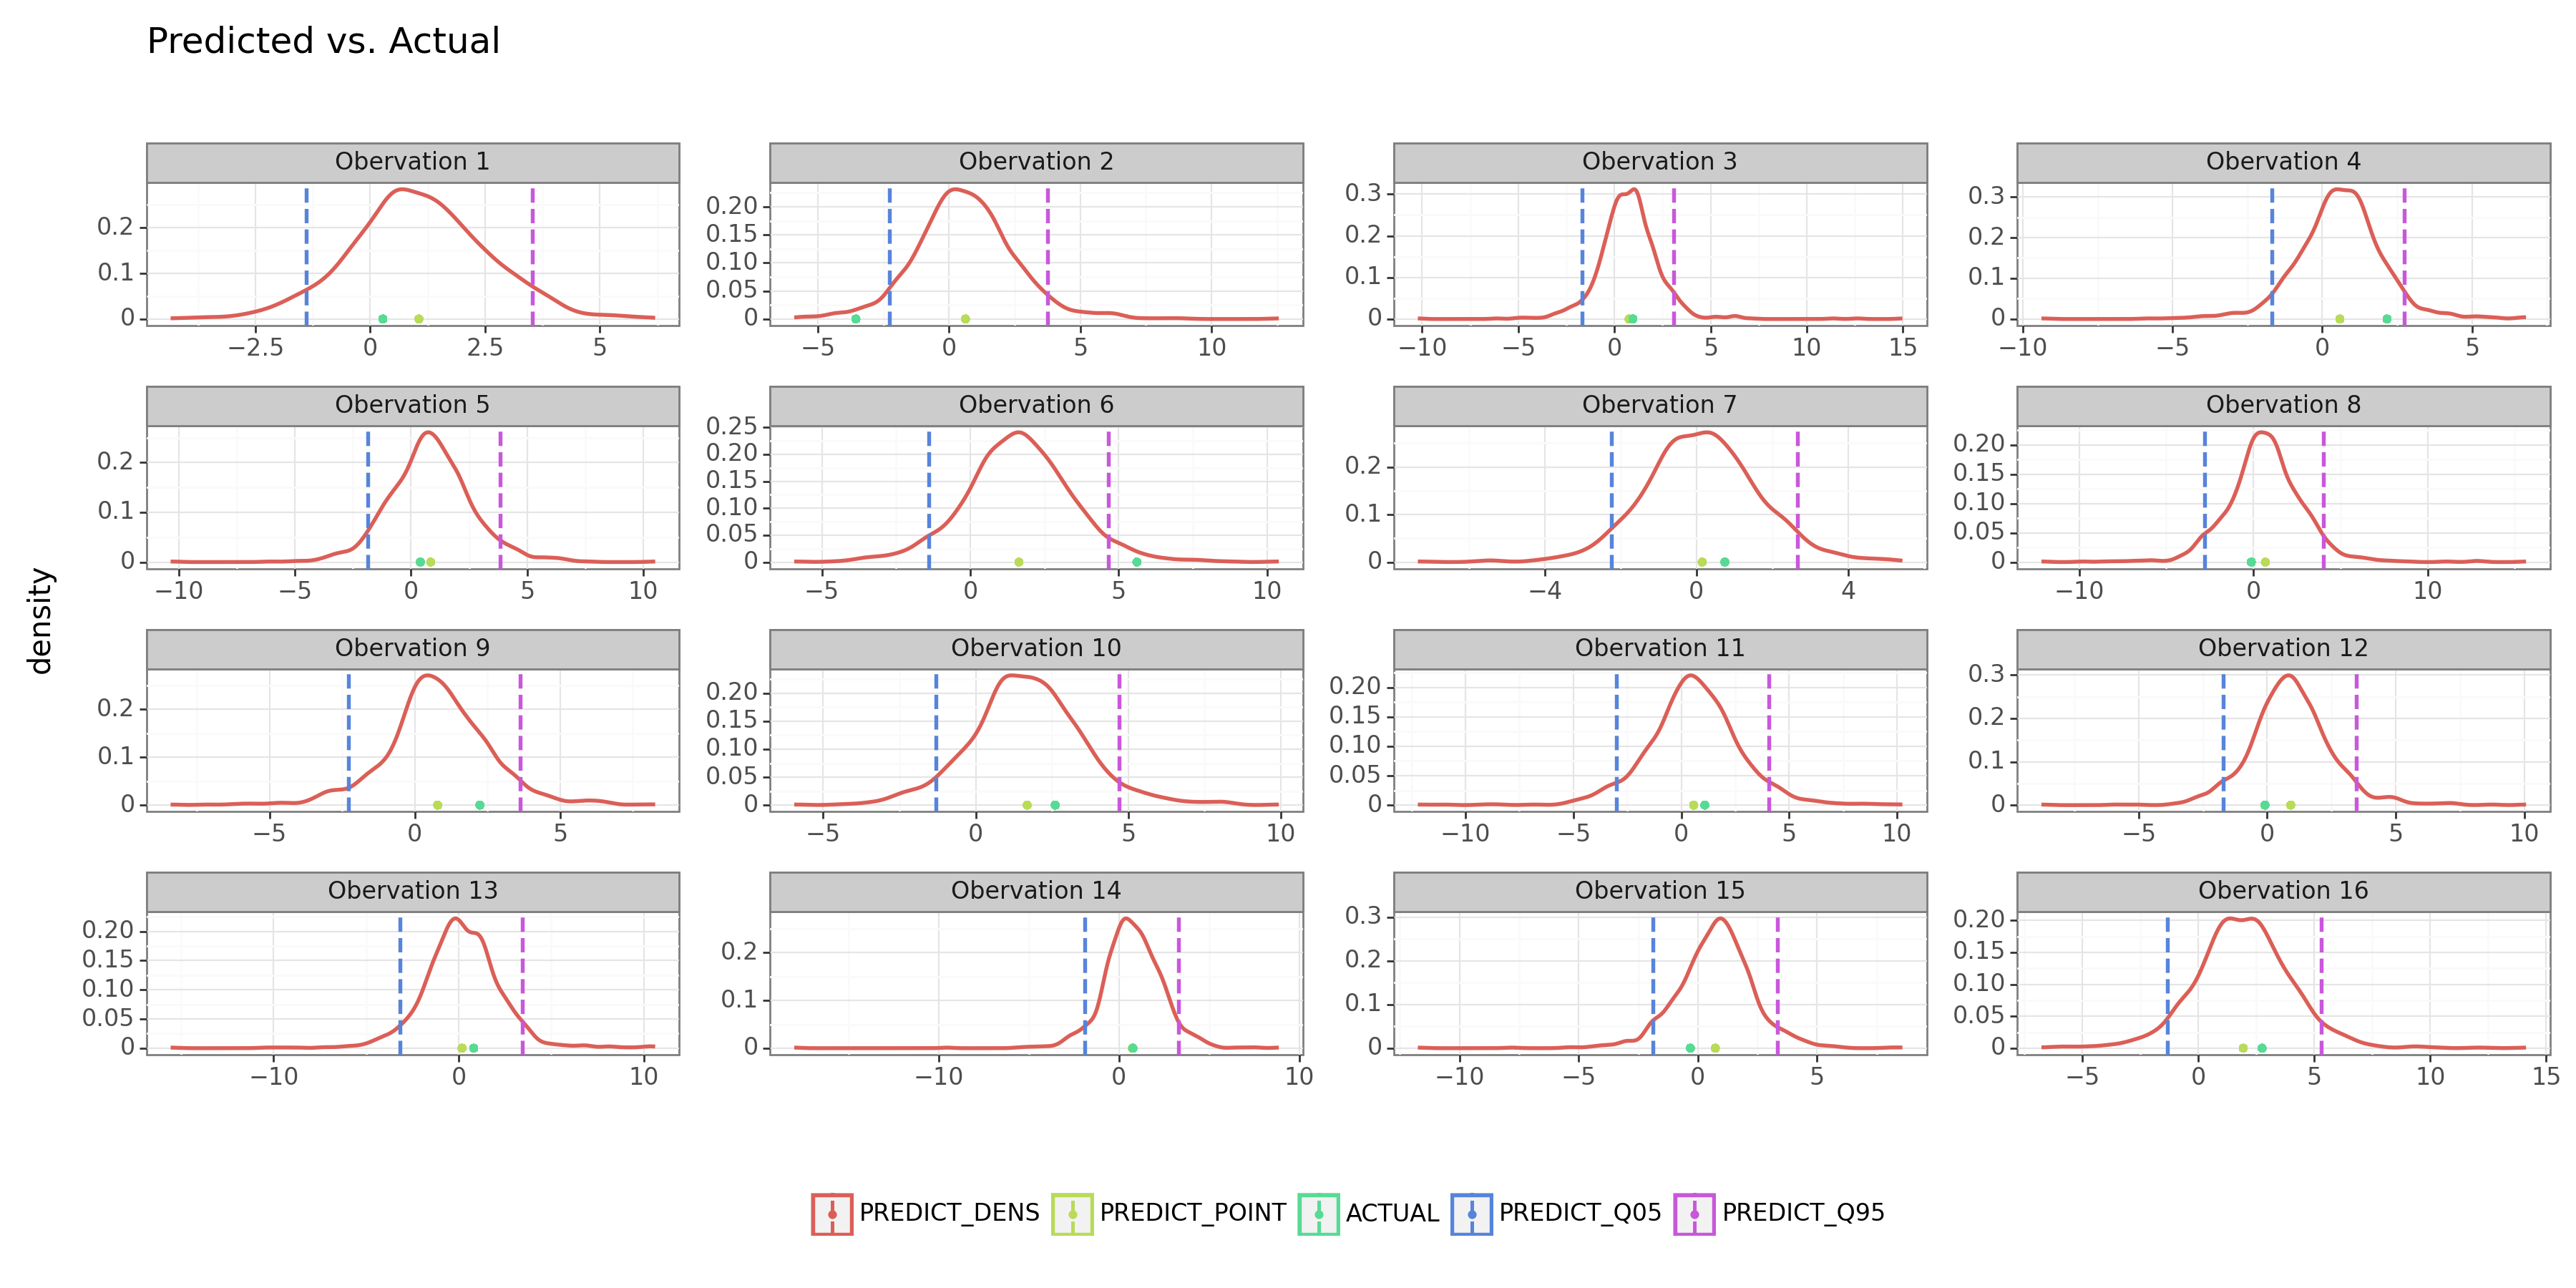

In [16]:
y_pred = []

n_examples = 16
q_sel = [0.05, 0.95]
y_sel=0
samples_arr = pred_samples.drop(columns="target").values.reshape(n_targets,-1,n_samples)

for i in range(n_examples):    
    y_samples = pd.DataFrame(samples_arr[y_sel,i,:].reshape(-1,1), columns=["PREDICT_DENS"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENS"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[1])
    y_samples["ACTUAL"] = y_test[i,y_sel]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=4) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          legend_title = element_blank()
         )
)

print(plot_pred)